# Memory-based Recommender System

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer


## import dataset

In [2]:
movies = pd.read_csv('../raw_data/movie/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
tags = pd.read_csv('../raw_data/movie/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [4]:
ratings = pd.read_csv('../raw_data/movie/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# standardize genres

movies['genres'] = movies['genres'].apply(lambda x: x.replace('|',' '))

In [7]:
# filter movies without ratings

movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]

## feature engineering

In [11]:
# merge datasets

merged = movies.merge(tags,on='movieId',how='left')

In [13]:
merged.fillna('',inplace=True)

In [15]:
merged = pd.DataFrame(merged.groupby('movieId')['tag'].apply(lambda x: '%s'%' '.join(x)))

In [17]:
merged_df = pd.merge(movies,merged,on='movieId',how='left')

In [19]:
merged_df['metadata'] = merged_df[['tag','genres']].apply(lambda x: ' '.join(x),axis = 1) 

In [20]:
merged_df

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy
...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,,Action Animation Comedy Fantasy
9720,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,,Animation Comedy Fantasy
9721,193585,Flint (2017),Drama,,Drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,,Action Animation


## countvectorizer

In [22]:
# transform metadata text into vector

model = CountVectorizer(stop_words='english')

vect = model.fit_transform(merged_df['metadata'])

In [23]:
vectorize_df = pd.DataFrame(vect.toarray(),index = merged_df.index.tolist())

## TruncatedSVD

In [27]:
# reduce dimension

svd = TruncatedSVD(n_components=25)
new_vectorize_df = svd.fit_transform(vectorize_df)

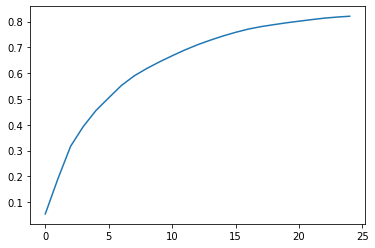

In [29]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [30]:
latent_df = pd.DataFrame(new_vectorize_df[:,0:25],index = merged_df.title.tolist())latent_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Toy Story (1995),0.906946,0.969612,0.642147,-0.496715,-0.916093,-0.982556,-0.730280,0.424489,0.068656,-0.213954,...,0.130425,-0.211220,-0.014326,-0.018544,0.003822,-0.039215,0.074736,-0.004225,-0.038593,-0.000402
Jumanji (1995),0.412993,0.161520,0.589471,-0.697434,-1.038275,-1.271058,-0.499947,0.377932,0.385751,0.340000,...,-0.576782,-0.207438,0.020400,0.017147,0.009835,-0.015207,0.090613,-0.019566,-0.015243,0.000522
Grumpier Old Men (1995),0.765626,0.916211,-0.122049,0.018001,0.281955,-0.207152,0.653873,0.063522,-0.031535,0.004238,...,0.012512,-0.061190,0.001086,-0.004309,-0.004154,0.005159,-0.004464,0.005918,-0.001259,-0.006741
Waiting to Exhale (1995),1.413731,0.503254,-0.641974,-0.225147,0.260513,-0.088929,0.437675,-0.028976,-0.023642,-0.003315,...,0.019017,-0.078481,-0.030053,-0.008145,-0.012142,-0.000818,-0.006712,0.005785,0.002927,-0.006821
Father of the Bride Part II (1995),0.523686,0.780103,0.056799,0.187916,0.098330,0.146743,-0.155329,-0.108346,-0.106465,0.029363,...,0.026957,-0.006598,-0.004277,-0.005789,-0.004673,0.011999,-0.004097,0.012951,-0.014367,-0.044789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.923350,0.707831,0.715075,-0.036019,-0.687505,-0.096936,-0.067330,-0.220352,0.447397,-0.731974,...,0.646229,-0.023754,-0.027646,-0.039763,0.004578,0.000119,0.083073,0.016770,-0.016708,-0.026369
No Game No Life: Zero (2017),0.677561,0.875247,0.265365,-0.083043,-0.268823,-0.424926,-0.435509,0.173466,0.286407,-0.471656,...,0.716771,-0.010544,-0.035974,-0.025917,0.026239,-0.013317,0.051027,0.033093,-0.011521,-0.020576
Flint (2017),0.648337,-0.412409,-0.520004,-0.243129,-0.021070,0.117877,-0.215087,-0.092358,0.007804,-0.007539,...,0.006576,-0.017690,-0.031130,-0.003882,-0.008036,-0.005910,-0.002306,-0.000047,0.004163,-0.000254
Bungo Stray Dogs: Dead Apple (2018),0.309432,-0.106349,0.551153,-0.081979,-0.588512,0.108112,0.193432,-0.182676,0.249515,-0.793534,...,0.597858,-0.010197,-0.022828,-0.021264,-0.006182,-0.002289,0.051506,-0.000239,-0.004390,-0.015588


In [31]:
# merge ratings and movies
r1 = pd.merge(movies[['movieId']],ratings,on='movieId',how='right')

In [32]:
# pivot df
r2 = r1.pivot(index = 'movieId',columns = 'userId',values = 'rating').fillna(0)

In [34]:
r2.shape

(9724, 610)

In [36]:
# keep only the first 200 components

svd = TruncatedSVD(n_components=200)

new_latent_df = svd.fit_transform(r2)

new_latent_df = pd.DataFrame(new_latent_df,index = merged_df.title.tolist())

new_latent_df.shape

(9724, 200)

## cosine_similarity

In [38]:
v1 = np.array(latent_df.loc['Toy Story (1995)']).reshape(1,-1)

In [40]:
v1.shape

(1, 25)

In [41]:
v2 = np.array(new_latent_df.loc['Toy Story (1995)']).reshape(1,-1)

In [42]:
v2.shape

(1, 200)

In [43]:
sim1 = cosine_similarity(latent_df,v1).reshape(-1)
sim1.shape

(9724,)

In [44]:
sim2 = cosine_similarity(new_latent_df,v2).reshape(-1)
sim2.shape

(9724,)

In [45]:
# hybrid_similarity = (content_similarity + collaborative_similarity) / 2

hybrid = (sim1 + sim2)/2

In [46]:
dictDf = {'content': sim1 , 'collaborative': sim2, 'hybrid': hybrid} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df.index)
recommendation_df

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Jumanji (1995),0.722533,0.469385,0.595959
Grumpier Old Men (1995),0.312837,0.357975,0.335406
Waiting to Exhale (1995),0.255554,0.025921,0.140738
Father of the Bride Part II (1995),0.442127,0.389007,0.415567
...,...,...,...
Black Butler: Book of the Atlantic (2017),0.670327,-0.013421,0.328453
No Game No Life: Zero (2017),0.774883,-0.013421,0.380731
Flint (2017),-0.000116,-0.013421,-0.006768
Bungo Stray Dogs: Dead Apple (2018),0.320770,-0.013421,0.153675


In [48]:
# best similarity -> hybrid

recommendation_df.sort_values('hybrid', ascending=False, inplace=True)
recommendation_df.head(10)

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.946745,0.645005,0.795875
"Monsters, Inc. (2001)",0.999651,0.554327,0.776989
Shrek (2001),0.912425,0.581425,0.746925
"Bug's Life, A (1998)",0.896110,0.529527,0.712818
Finding Nemo (2003),0.895503,0.519834,0.707668
Antz (1998),0.999651,0.392719,0.696185
Toy Story 3 (2010),0.913200,0.478096,0.695648
Aladdin (1992),0.795154,0.577991,0.686573
Ice Age (2002),0.895866,0.430948,0.663407
